<hr>
Este material ha sido construido en conjunto con material suministrado por los profesores Pedro Atencio (Instituto Tecnológico Metropolitano), Carlos Mera (Instituto Tecnológico Metropolitano), Albeiro Espinosa y Diego Patiño (Universidad Nacional de Colombia, Sede Medellín); a ellos les damos crédito.
<hr>

#  <center> VISIÓN ARTIFICIAL </center>
## Agenda del día


### UNIDAD 11 - SELECCIÓN DE CARACTERÍSTICAS E INTRODUCCIÓN AL RECONOCIMIENTO DE PATRONES

<ul>
  <li>Repaso de extracción.</li>
  <li>Selección de características.</li>
  <li>Introducción al reconocimiento de patrones.</li>

</ul>

In [1]:
#Lectura de librerías útiles
%matplotlib inline

import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
import warnings
from skimage import morphology
from skimage.measure import label, regionprops
import pandas as pd
warnings.filterwarnings('ignore')

#Definir funciones que agilizan la lectura de imágenes
def img_read(filename, mode = 'color'):
    if(mode == 'color'):
        return cv2.cvtColor(cv2.imread(filename),cv2.COLOR_BGR2RGB)
    elif(mode=='grayscale' or mode=='greyscale' or mode == 'gray' or mode == 'grey'):
        return cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    else:
        return None

<center><img src = res/intro.png></center>

En esta sesión haremos uso del conjunto de datos MNIST para ejemplificar las fases de extracción, selección y clasificación.

Este conjunto de datos está conformado por 70.000 imágenes de dígitos del 0 al 9 escritos a mano. La tarea es, pues, clasificar los dígitos.

<center><img src = res/digitos.png></center>

# 1.0 Repaso de Segmentación/Extracción de Características

A continuación, repasemos el proceso de extracción de características para los dígitos del conjunto de datos MNIST. Para esto, hacemos uso de la librería Keras, la cual tiene el conjunto listo para ser utilizado.

Keras devuelve los datos en forma de un conjunto de entrenamiento  (x_train, y_train) de 60000 entradas donde cada entrada de entrenamiento $x_i$ es una matriz conformada por 28x28 píxeles, y cada etiqueta de entrenamiento $y_i$ es un número del 0 al 9 indicando la clase de la entrada correspondiente.

El conjunto de prueba (x_test, y_test) se puede describir de la misma forma, con la salvedad de que está conformado por 10000 entradas.

In [2]:
#Importar datasets preparados para trabajar
from keras.datasets import mnist

#Cargar el dataset, conjuntos de entrenamiento y pruebas
(x_train, y_train), (x_test, y_test) = mnist.load_data()

#Imprimir resultados de entrenamiento (labels)
print("Conjunto de entrenamiento: ", x_train.shape)
print("Etiquetas de entrenamiento: ", y_train.shape)
print("Conjunto de prueba: ", x_test.shape)
print("Etiquetas de prueba: ", y_test.shape)

2025-02-18 15:13:59.682686: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Conjunto de entrenamiento:  (60000, 28, 28)
Etiquetas de entrenamiento:  (60000,)
Conjunto de prueba:  (10000, 28, 28)
Etiquetas de prueba:  (10000,)


# 1.1 Segmentación

Para este caso de estudio, la segmentación es trivial pero en todo caso necesaria.

Examinemos una imagen del conjunto de entrenamiento:

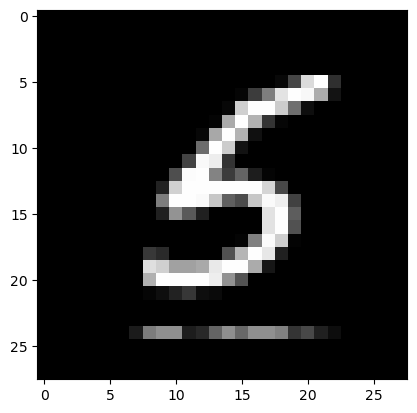

In [3]:
#Mostrar una imagen del dataset de entrenamiento
im = x_train[775]
plt.imshow(im, cmap='gray');

Los gradientes de intensidad en los bordes de la imagen no contienen información que nos sea demasiado útil para trabajar con las imágenes. Por este motivo, aplicamos una umbralización simple de manera que podamos extraer características a partir de la máscara binaria.

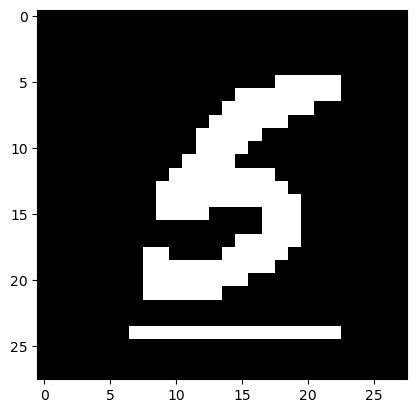

In [4]:
#Extraer máscara binaria de todos los elementos de entrenamiento y pruebas

for i in range(len(x_train)):
    x_train[i][x_train[i]>0.1] = 1
    x_train[i][x_train[i]<=0.1] = 0

for i in range(len(x_test)):
    x_test[i][x_test[i]>0.1] = 1
    x_test[i][x_test[i]<=0.1] = 0

plt.imshow(x_train[775], cmap='gray');

# 1.2 Morfología

Como vemos arriba, algunas de las imágenes resultantes tienen componentes que no son de interés. De manera empírica definimos eliminar los componentes que no son de interés mediante la operación <i>remove small objects</i> de la librería scikit-image.

En algunas imágenes de ceros, el círculo no está cerrado completamente, sin embargo, decidimos no implementar funciones de morfología para corregir dichos errores puesto que esto puede incidir negativamente en imágenes donde los huecos sean pequeños.

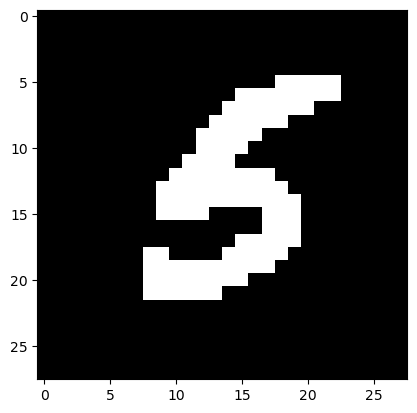

In [5]:
#Aplicar remoción de objetos pequeños sobre las imágenes binarias
img = x_train[775]
img *= morphology.remove_small_objects(img.astype(bool), min_size = 50)
plt.imshow(img, cmap = 'gray');

# 1.3 Extracción de Características

Ya que el conjunto de imágenes MNIST no contiene información de color o textura que nos sea de utilidad, nos centraremos en el uso de descriptores de forma y topología.

## 1.3.1 Momentos de HU

Como se vio en la sesión anterior, los momentos de Hu son los momentos más útiles para tareas de clasificación al ser invariantes al tamaño, la rotación y la traslación.

Adicionalmente, tomamos el logaritmo de los mismos para garantizar que se mantengan en un rango de valores razonable.

In [6]:
#Definir función que extrae los momentos

def get_moments_hu(props, features):
    moments_hu = props.moments_hu
    moments_hu = np.sign(moments_hu) * np.log(np.abs(moments_hu))
    features['hu0'] = moments_hu[0]
    features['hu1'] = moments_hu[1]
    features['hu2'] = moments_hu[2]
    features['hu3'] = moments_hu[3]
    features['hu4'] = moments_hu[4]
    features['hu5'] = moments_hu[5]
    features['hu6'] = moments_hu[6]
    return features

## 1.3.2 Características Topológicas

Entre las características topológicas, la de mayor interés es el número de euler (1 - la cantidad de huecos en el objeto). Decidimos no usar el número de huecos, ya que está correlacionado con el número de huecos.

In [7]:
#Obtener propiedades topológicas de la imagen

def get_features_topological(props, features):
    features['euler_num'] = props.euler_number
    return features

## 1.3.3 Características de Forma



In [8]:
#Función de características de forma

def get_features_area(props, features):

    features['orientation'] = props.orientation
    features['area_to_convex_ratio'] = props.area/props.convex_area
    features['compacity'] = props.perimeter**2 / props.area
    features['roundness'] = 4*math.pi*props.area / (props.perimeter**2)
    features['area_perimeter_ratio'] = props.area / props.perimeter
    features['elongation'] = props.major_axis_length / props.minor_axis_length
    features['solidity1'] = props.area / props.convex_area
    features['solidity2'] = props.area / props.filled_area
    return features

## Juntando lo anterior

Combinamos lo anterior (excepto umbralización) en una sola función get_features en la que se aplicamos morfología y extracción de las características.

Esta función de vuelve un diccionario de características <i>features</i> con las características extraidas de una imagen del conjunto de datos.



In [ ]:
#Función que extrae características de una imagen

def get_features(img):
  features = {}
  img *= morphology.remove_small_objects(img.astype(bool), min_size = 20)
  label_img = label(img)
  props = regionprops(label_img)[0]
  features = get_moments_hu(props, features)
  features = get_features_topological(props, features)
  features = get_features_area(props, features)
  return features

features_0 = get_features(x_train[0])
columns = list(features_0.keys())
columns.append('class')

#Crear dataset de características de entrenamiento como dataframe de pandas
df_train = pd.DataFrame(columns=columns)

#Extraer características de todas las imágenes de entrenamiento
for i in range(len(x_train)):
    features = get_features(x_train[i])
    df_train.loc[i] = [features[feature] for feature in features.keys()]+[y_train[i]]

In [ ]:
#Volverlo un csv
df_train.to_csv('data_train.csv')

<span style="font-size:24px">Las 2 celdas anteriores calculan las características de todo el dataset, es un código que tarda mucho tiempo en ejecutarse dado el tamaño del dataset, por lo cuál simplemente tomamos el archivo ya dado por una ejecución previa.</span>

In [9]:
#Leer el set como un dataframe de pandas
df_train = pd.read_csv('data_train.csv')

In [10]:
#Mostrar los primeros ID del dataset
df_train.head()

,Unnamed: 0,hu0,hu1,hu2,hu3,hu4,hu5,hu6,euler_num,orientation,area_to_convex_ratio,compacity,roundness,area_perimeter_ratio,elongation,solidity1,solidity2,class
0,0,-1.030334,-3.382183,-5.921228,-7.284824,-14.569056,-9.615941,-14.035736,1,-0.314864,0.544262,51.040868,0.246202,1.803412,1.770921,0.544262,1.000000,5
1,1,-1.152595,-4.044950,-7.522026,-8.279011,18.609868,-10.516197,16.183418,0,-0.600123,0.676923,55.701218,0.225603,1.777559,1.562802,0.676923,0.709677,0
2,2,-0.658067,-3.536645,-2.466380,-5.307169,-9.844151,-7.455273,-9.352959,1,1.431272,0.404040,56.511648,0.222368,1.457208,1.408097,0.404040,1.000000,4
3,3,-0.769493,-1.684218,-6.996959,-8.666822,-17.579829,11.850399,-16.559834,1,-0.543694,0.800000,29.765909,0.422173,1.795875,5.249216,0.800000,1.000000,1
4,4,-1.262993,-4.296575,-4.179752,-6.115294,-11.306249,-8.477602,12.506082,0,0.050033,0.663551,45.941695,0.273529,1.758088,1.550739,0.663551,0.934211,9


In [ ]:
#Extraer la parte del dataset que corresponde a pruebas
df_test = pd.DataFrame(columns=columns)

#Obtener las características de las imágenes de prueba
for i in range(len(x_test)):
    features = get_features(x_test[i])
    df_test.loc[i] = [features[feature] for feature in features.keys()]+[y_test[i]]


In [ ]:
#Guardar como csv
df_test.to_csv('data_test.csv')

<span style="font-size:24px">Similar al caso anterior, la cantidad de datos es muy grande al igual que el tiempo de procesamiento, por lo cuál se toma el archivo directamente.</span>

In [11]:
#Leer el csv
df_test = pd.read_csv('data_test.csv')
# Mostrar los primeros ID del dataset
df_test.head()

,Unnamed: 0,hu0,hu1,hu2,hu3,hu4,hu5,hu6,euler_num,orientation,area_to_convex_ratio,compacity,roundness,area_perimeter_ratio,elongation,solidity1,solidity2,class
0,0,-0.804802,-3.138292,-2.844154,-5.174724,9.957690,11.647921,-9.303848,1,-0.093700,0.522523,45.776253,0.274517,1.591875,1.656137,0.522523,1.000000,7
1,1,-0.962441,-3.503293,-4.015799,-6.463361,12.625727,8.251841,11.788889,1,0.340228,0.550000,52.158727,0.240926,1.778601,1.632293,0.550000,1.000000,2
2,2,-0.525733,-1.140627,-5.777995,-6.137164,-12.094743,-6.707824,19.440251,1,-0.292252,0.780488,34.724702,0.361886,1.357597,6.698557,0.780488,1.000000,1
3,3,-1.404304,-5.665310,-7.427943,-10.728971,-20.642337,14.685048,-19.911730,0,-0.181032,0.759843,41.369827,0.303757,2.159916,1.276931,0.759843,0.807531,0
4,4,-0.986712,-7.854811,-4.475459,-7.592898,14.613329,-12.411038,13.701969,1,0.472922,0.504202,55.904383,0.224783,1.465101,1.054301,0.504202,1.000000,4


# 2.0 Selección de Características

El problema de selección de características puede entenderse como una instancia del problema de la mochila.

<center><img src = res/pesos.png></center>

# 2.1. Enfoques Estadísticos

Se le asigna un puntaje estadístico a cada característica con base en una medición estadística, por ejemplo:

- Varianza $\sigma^2$
- Chi-Cuadrado $\chi^2$
- Anova.
- Entropia.
- etc.

Para ejemplificar los conceptos de selección de características, utilizaremos algunos casos más sencillos...

## 2.1.1. Selección de Características por Varianza

In [12]:
from sklearn.feature_selection import VarianceThreshold

#Crear una array de numpy
X = np.array([[0, 0, 1], [0, 1, 0], [1, 0, 0], [0, 1, 1], [0, 1, 0], [0, 1, 1]])

#Aplicar selector de características por varianza
selector = VarianceThreshold(threshold=0.2)
X_new = selector.fit_transform(X)
print("Original features: ",X)
print("Selected features: ",X_new)

Original features:  [[0 0 1]
 [0 1 0]
 [1 0 0]
 [0 1 1]
 [0 1 0]
 [0 1 1]]
Selected features:  [[0 1]
 [1 0]
 [0 0]
 [1 1]
 [1 0]
 [1 1]]


In [13]:
from sklearn.datasets import load_iris
from tabulate import tabulate

#Cargar un dataset de iris
iris = load_iris()

#Extraer las características del dataset escogido
X, y = iris.data, iris.target  
#Imprimir una tabla
header = ["feature_1", "feature_2", "feature_3", "feature_4"]
table = tabulate(X[0:5,:], headers=header, tablefmt="fancy_grid")
print(table)

╒═════════════╤═════════════╤═════════════╤═════════════╕
│   feature_1 │   feature_2 │   feature_3 │   feature_4 │
╞═════════════╪═════════════╪═════════════╪═════════════╡
│         5.1 │         3.5 │         1.4 │         0.2 │
├─────────────┼─────────────┼─────────────┼─────────────┤
│         4.9 │         3   │         1.4 │         0.2 │
├─────────────┼─────────────┼─────────────┼─────────────┤
│         4.7 │         3.2 │         1.3 │         0.2 │
├─────────────┼─────────────┼─────────────┼─────────────┤
│         4.6 │         3.1 │         1.5 │         0.2 │
├─────────────┼─────────────┼─────────────┼─────────────┤
│         5   │         3.6 │         1.4 │         0.2 │
╘═════════════╧═════════════╧═════════════╧═════════════╛


In [14]:
#Selección de características
selector = VarianceThreshold(threshold=0.6) 
X_new = selector.fit_transform(X)

"""Básicamente, el método get_support() devuelve un array booleano que
indica si la característica es seleccionada o no, entonces con np.where 
vemos que indices son esos, y con np.squeeze para quitamos dimensiones 
de tamaño 1 o ejes inncesarios de un array"""
sel_features = np.squeeze(np.where(selector.get_support()==True)) 

#Mostrar características seleccionadas
print("Features selected: ", sel_features)
print(selector.get_support())

Features selected:  [0 2]
[ True False  True False]


In [15]:
#imprimir las características seleccionadas como tablas
headers = ["feature "+str(i+1) for i in sel_features]
table = tabulate(X_new[0:5,], headers, tablefmt="fancy_grid")
print(table)

╒═════════════╤═════════════╕
│   feature 1 │   feature 3 │
╞═════════════╪═════════════╡
│         5.1 │         1.4 │
├─────────────┼─────────────┤
│         4.9 │         1.4 │
├─────────────┼─────────────┤
│         4.7 │         1.3 │
├─────────────┼─────────────┤
│         4.6 │         1.5 │
├─────────────┼─────────────┤
│         5   │         1.4 │
╘═════════════╧═════════════╛


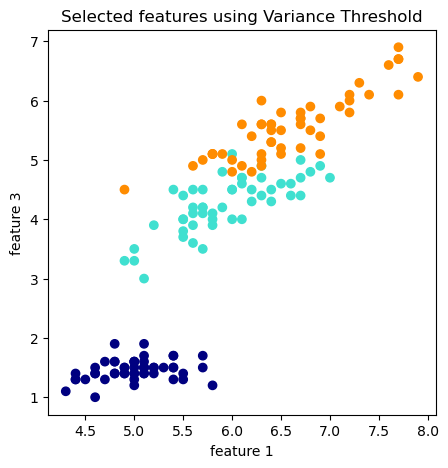

In [16]:
#Realizar la impresión de la característica 1 vs la característica 3 escogidas
colors = ['navy', 'turquoise', 'darkorange']

# El iris.target_names nos da un arreglo con el número de la etiqueta a la que pertenece cada elemento
target_names = iris.target_names

# Aprovechamos las etiquetas para darles el color correcto
color = [colors[i] for i in y]

plt.figure(figsize=(5,5))
plt.title("Selected features using Variance Threshold")

# Ponemos todos los datos de las 2 columnas seleccionadas
plt.scatter(X_new[:, 0], X_new[:, 1], color=color)

plt.xlabel("feature "+str(sel_features[0]+1))
plt.ylabel("feature "+str(sel_features[1]+1))
plt.show()

<span style="font-size:20px">Vemos que efectivamente por medio de esas 2 características, los datos se separan bien.</span>

## 2.1.2. Selección Por Prueba Estadística $\chi^2$

Se pueden utilizar técnicas estadísticas como chi-cuadrado $\chi^2$ para seleccionar características. Esta prueba responde la siguiente pregunta:<br/><br/>

<center> <font size=5>¿Qué tan independientes son las variables de la respuesta? </font></center>

Se busca el mayor aporte de información/mayor correlación con respecto a la variable de respuesta.
<br>


In [17]:
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest, chi2

#Realizar una lectura del dataset de iris
iris = load_iris()
X, y = iris.data, iris.target

#Utilizar como selector de características los K vecinos mejores
#Especificamos para las 2 mejores características independientes
selector = SelectKBest(score_func=chi2, k=2)

#Obtener las características elegidas por el selector
X_new = selector.fit_transform(X, y)

# Vemos especificamente de que columnas son las características seleccionadas
sel_features = np.squeeze(np.where(selector.get_support()==True))

print("Features selected: ", sel_features)
print(X_new[:5,:])

Features selected:  [2 3]
[[1.4 0.2]
 [1.4 0.2]
 [1.3 0.2]
 [1.5 0.2]
 [1.4 0.2]]


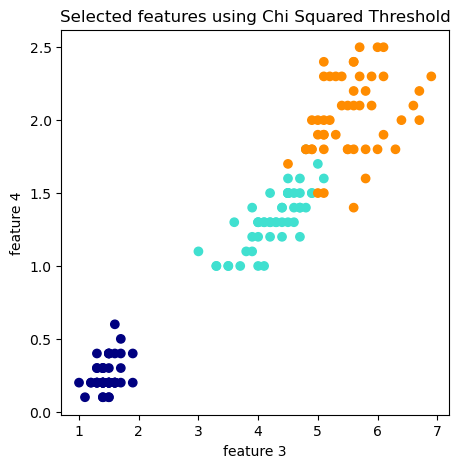

In [18]:
#Imprimir features escogidos en forma gráfica
colors = ['navy', 'turquoise', 'darkorange']

target_names = iris.target_names

color = [colors[i] for i in y]

plt.figure(figsize=(5,5))
plt.title("Selected features using Chi Squared Threshold")

plt.scatter(X_new[:, 0], X_new[:, 1], color=color)

plt.xlabel("feature "+str(sel_features[0]+1))
plt.ylabel("feature "+str(sel_features[1]+1))
plt.show()

<span style="font-size:20px">Nuevamente, por medio de esas 2 características tomadas por prueba de chi-cuadrado, los datos se separan bien.</span>

# 3. Wrappers y Modelos Embebidos

## 3.1. Wrappers

Se utiliza un modelo predictivo para evaluar diferentes combinaciones de características a partir de un método de búsqueda. Por ejemplo: selección hacia adelante, selección hacia atrás, etc. Cuando un conjunto dado de combinaciones ha sido probado, se selecciona el mejor subconjunto de características.

El método se ejecuta en k iteraciones de manera recursiva y el número de características es el definido por el usuario.

<center><img src = res/wrapper.png></center>

In [19]:
from sklearn.datasets import load_digits
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Load the digits dataset
digits = load_digits()
"""Convertir el arreglo de imágenes en un array donde cada fila contiene los pixeles aplanados de la 
imagen, el -1 significa calcular la segunda dimensión de manera que el tamaño total del array sea el mismo""" 
X = digits.images.reshape((len(digits.images), -1))
y = digits.target
print(X.shape)

(1797, 64)


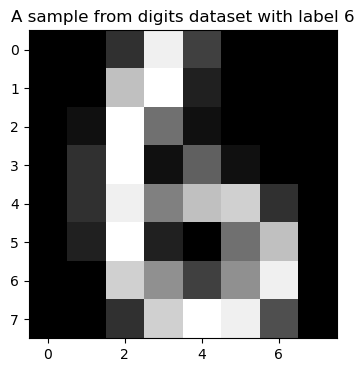

In [20]:
index = 234
# Tomo el elemento index-ésimo de X y lo convierto en una matriz de 8x8
img = np.reshape(X[index,:], (8,8))
label = y[index]
# Plot pixel ranking
plt.figure(figsize=(4,4))
plt.imshow(img, cmap='gray')
plt.title("A sample from digits dataset with label "+str(label))
plt.show()

In [21]:
#Crear el objeto RFE y se rankea para cada píxel
model = LogisticRegression()
#Mejores 32 características
rfe = RFE(estimator=model, n_features_to_select=32, step=1) 
rfe.fit(X, y)
ranking = rfe.ranking_.reshape(digits.images[0].shape)
print(ranking)

[[33 18  1  2  1  1  1 20]
 [25  7  9  1  1 15  4 22]
 [21  8  5  1  1  1  1 24]
 [23 12  1  1  1  1  1 29]
 [32  1  6  1  1  1  1 31]
 [28  1  1  1  1 10  1 26]
 [27 14 13  1  1  1  3 17]
 [30 19  1  1 11  1  1 16]]


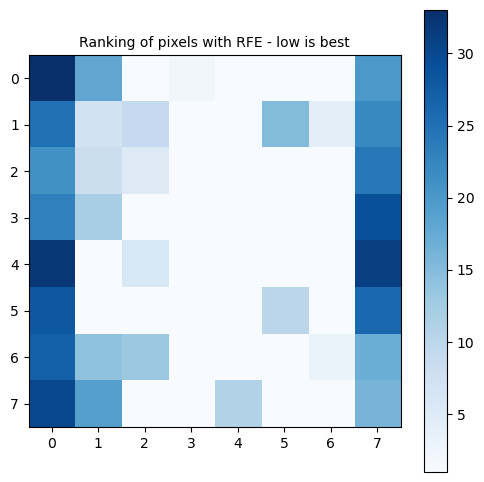

In [22]:
#Plotear el ranking de pixeles, los menores valores son los mejores
plt.figure(figsize=(6,6))
plt.imshow(ranking, cmap=plt.cm.Blues)
plt.colorbar()
plt.title("Ranking of pixels with RFE - low is best", fontsize=10)
plt.show()

## 3.2. Modelos Embebidos

Se hace uso del modelo predictivo para dos tareas al mismo tiempo: para evaluar el rendimiento del subconjunto y para **aprender** cual subconjunto es el mejor.

Ejemplos: Regresiones con Penalización Lasso/Ridge, Arboles de Decisión.

<img src = res/embebido.png>

In [23]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
#Cargar dataset de 'digits'
digits = load_digits()
X = digits.images.reshape((len(digits.images), -1))
y = digits.target

#Modelo de predicción a utilizar
predictor = ExtraTreesClassifier()
#Se entrena el modelo
predictor.fit(X, y)

ExtraTreesClassifier()

In [24]:
#El argumento prefit=True indica que el modelo ya ha sido entrenado
model = SelectFromModel(predictor, threshold=0.02, prefit=True)
#Dataset con las características seleccionadas
X_new = model.transform(X) 

#Obtenemos el vector de características seleccionadas
selection = model.get_support()
selection_map = np.reshape(selection, (8,8))

num_selected_features = np.count_nonzero(selection)
print(selection)
print("El numero de características seleccionadas como píxeles clave son: ",num_selected_features)

[False False False False False  True False False False False  True False
 False  True False False False False  True  True  True  True False False
 False False  True  True  True  True  True False False  True  True  True
  True  True  True False False False  True  True  True False False False
 False False False  True False  True  True False False False  True False
  True  True False False]
El numero de características seleccionadas como píxeles clave son:  27


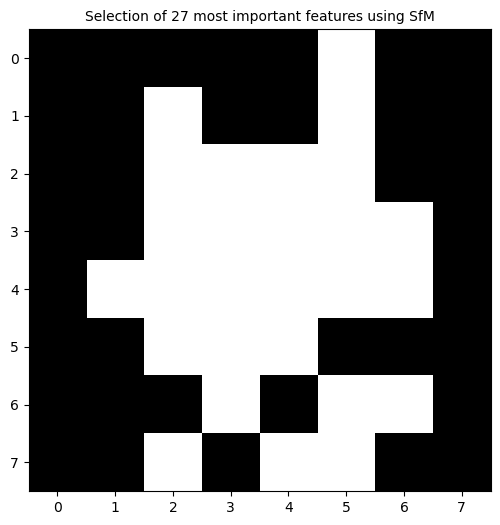

In [25]:
#Plot pixel ranking
plt.figure(figsize=(6,6))
plt.imshow(selection_map, cmap='gray')
plt.title("Selection of "+str(num_selected_features)+" most important features using SfM", fontsize=10)
plt.show()

# 4. Transformaciones para Reducción

La transformación de características consiste en obtener un conjunto de características G a partir de una transformación lineal o no-lineal de un conjunto de datos X.

<center><img src = res/redu.png></center>


## 4.1. Análisis de Componentes Principales (PCA)

Esta técnica consiste en proyectar un conjunto de datos sobre un hiperespacio compuesto por las dimensiones principales de los datos.

¿Cuáles $\lambda_i \in V$ son mejores?

<center><img src = res/pers.png></center>

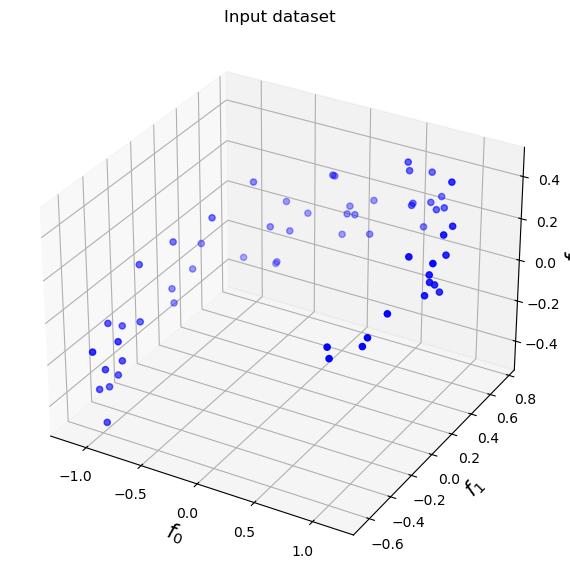

In [26]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

""" Caracteristicas de los datos aleatorios """
#Semilla
np.random.seed(4)
#Numero de muestras
m = 60
#Pesos
w1, w2 = 0.1, 0.3
#Ruido
noise = 0.1

#Generar datos aleatorios
angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
#Generar un array mx3 con los valores sin inicializar, esto es como aleatorizar los valores
X = np.empty((m, 3))

#Creamos las coordenadas de los puntos
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], color='b')

ax.set_title("Input dataset")
ax.set_xlabel(r'$f_0$', fontsize=15)
ax.set_ylabel(r'$f_1$', fontsize=15)
ax.set_zlabel(r'$f_2$', fontsize=15);

##  4.2. PCA Usando Descomposición en Valores Singulares

Los valores propios pueden ser extraidos usando una factorización de matrices. Por ejemplo, la descomposición en valores singulares, que se puede expresar como:

$$X = U \cdot \sum \cdot V^T$$

Donde $V$ es la matriz que contiene los valores propios de $X$

$$
\mathbf{V} =
\begin{pmatrix}
  \mid & \mid & & \mid \\
  \mathbf{c_1} & \mathbf{c_2} & \cdots & \mathbf{c_n} \\
  \mid & \mid & & \mid
\end{pmatrix}
$$

In [27]:
from numpy.linalg import svd

#Centrar los datos por medio de una extracción del promedio a lo largo del eje Y
X_centered = X - X.mean(axis=0)
#Aplicar Single Value Decomposition, esto es una técnica de factorización de matrices
U, s, Vt = svd(X_centered)
#Matriz de valores propios
print(Vt) 

[[ 0.93636116  0.29854881  0.18465208]
 [-0.34027485  0.90119108  0.2684542 ]
 [-0.08626012 -0.31420255  0.94542898]]


Una vez extraida $V$, podemos proyectar la matriz X sobre uno o más valores propios o componentes principales para reducir la dimensionalidad de X:

$$ X_{new} = X \cdot V^{'} $$

In [28]:
# Proyectar X en los primeros 2 componentes principales, ya que con eso basta para plano XY
V_prime = Vt.T[:, :2]
X2D = np.dot(X_centered, V_prime)

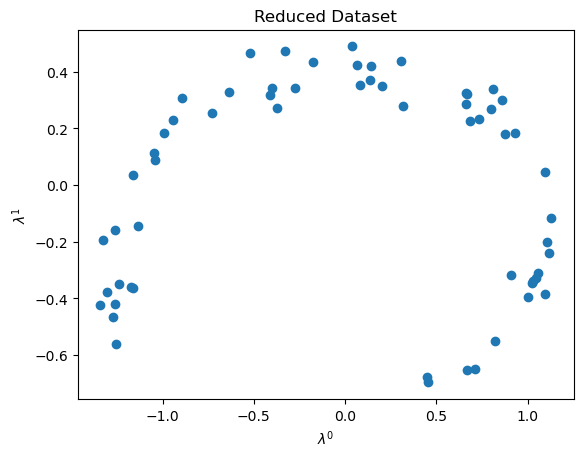

In [29]:
plt.title("Reduced Dataset")
plt.scatter(X2D[:,0], X2D[:,1])
#Puede ser interpretado como la sombra.
plt.xlabel(r'$\lambda^0$')
plt.ylabel(r'$\lambda^1$')
plt.show()

## 4.3. PCA Usando Scikit-Learn

In [30]:
from sklearn.decomposition import PCA

#Aplicar PCA con 2 componentes sobre X
pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

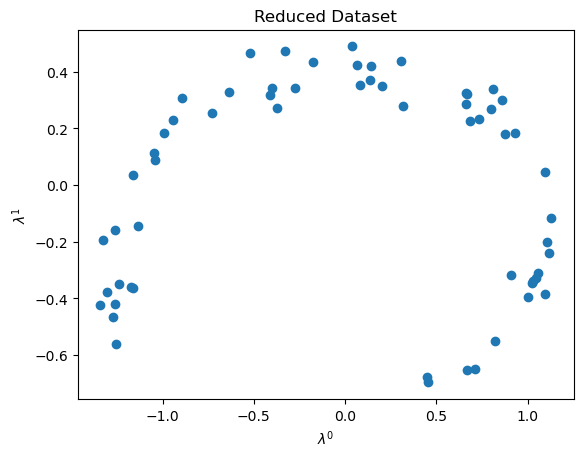

In [31]:
plt.title("Reduced Dataset")
plt.scatter(X2D[:,0], X2D[:,1])
#Puede ser interpretado como la sombra.
plt.xlabel(r'$\lambda^0$')
plt.ylabel(r'$\lambda^1$')
plt.show()

In [32]:
print("First 2 components by SVD: ",Vt[:2])
print("First 2 components by Scikit: ", pca.components_)

First 2 components by SVD:  [[ 0.93636116  0.29854881  0.18465208]
 [-0.34027485  0.90119108  0.2684542 ]]
First 2 components by Scikit:  [[ 0.93636116  0.29854881  0.18465208]
 [-0.34027485  0.90119108  0.2684542 ]]


<span style="font-size:20px">Vemos que los valores de las matrices son exactamente iguales, por eso dan la misma proyección.</span>

Apliquemos PCA sobre el conjunto de datos Iris.

In [33]:
iris = load_iris()
X, y = iris.data, iris.target

#Aplicar PCA sobre X con los 2 componentes principales
pca = PCA(n_components=2)
X_new = pca.fit_transform(X)

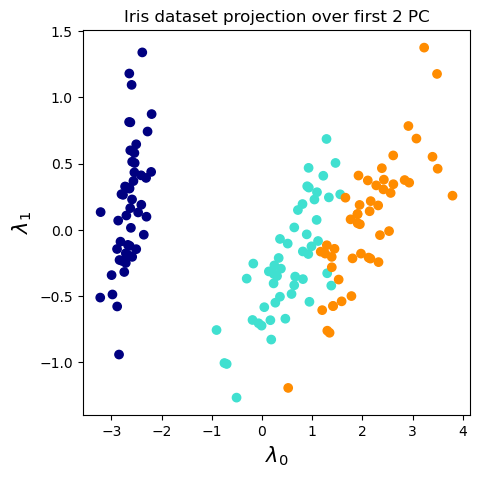

In [34]:
#Imprimir los dos componentes principales
colors = ['navy', 'turquoise', 'darkorange']

target_names = iris.target_names

color = [colors[i] for i in y]
label = [target_names[i] for i in y]

plt.figure(figsize=(5,5))
plt.title("Iris dataset projection over first 2 PC")

plt.scatter(X_new[:, 0], X_new[:, 1], color=color)

plt.xlabel(r'$\lambda_0$', fontsize=15)
plt.ylabel(r'$\lambda_1$', fontsize=15)
plt.show()

<hr>

## 4.4. PCA No-Lineal / Kernel PCA

En casos más complejos, podemos utilizar funciones matemáticas no-lineales o de kernel para realizar transformaciones complejas en los datos.

In [35]:
from sklearn.datasets import make_circles
#Seleccionar la semilla
np.random.seed(0)
X, y = make_circles(n_samples=400, factor=.3, noise=.05)

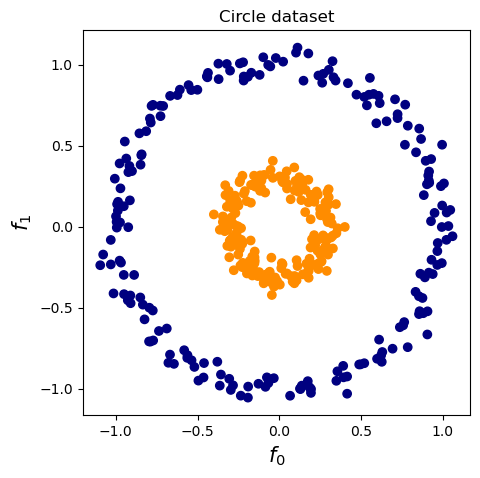

In [36]:
#Imprimir los datos escogidos
colors = ['navy', 'darkorange']

target_names = iris.target_names

color = [colors[i] for i in y]

plt.figure(figsize=(5,5))
plt.title("Circle dataset")

plt.scatter(X[:, 0], X[:, 1], color=color)

plt.xlabel(r'$f_0$', fontsize=15)
plt.ylabel(r'$f_1$', fontsize=15)
plt.show()

Evaluemos el resultado de un PCA simple.

In [37]:
#Aplicar PCA sobre el set de datos
pca = PCA(n_components=1)
X_new = pca.fit_transform(X)

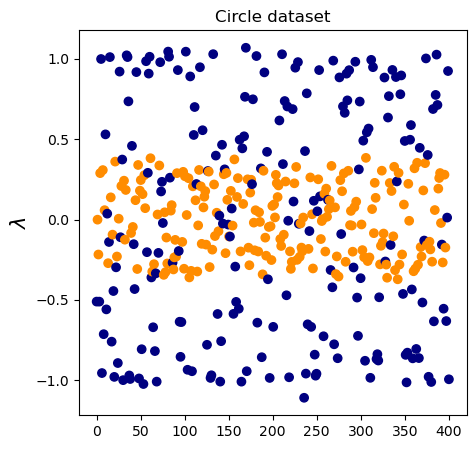

In [38]:
#Imprimirlo como una imagen 2D
colors = ['navy', 'darkorange']

target_names = iris.target_names

color = [colors[i] for i in y]

plt.figure(figsize=(5,5))
plt.title("Circle dataset")

plt.scatter(np.linspace(0,len(X_new),len(X_new)), X_new, color=color)

plt.ylabel(r'$\lambda$', fontsize=15)
plt.show()

Ahora con Kernel PCA:

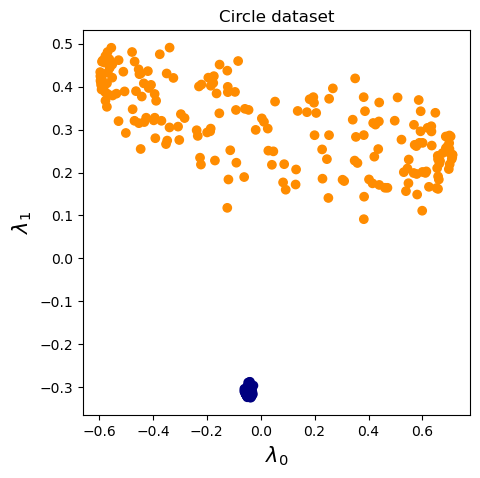

In [39]:
from sklearn.decomposition import KernelPCA

#Aplicar un kernel PCA no lineal e imprimirlo
# El fit_inverse_transform en True es para que el modelo aprenda como invertir la transformación de PCA no lineal
kpca = KernelPCA(kernel="rbf", fit_inverse_transform=True, gamma=10)
X_kpca = kpca.fit_transform(X)

colors = ['navy', 'darkorange']

color = [colors[i] for i in y]

plt.figure(figsize=(5,5))
plt.title("Circle dataset")

plt.scatter(X_kpca[:, 0], X_kpca[:, 1], color=color)

plt.xlabel(r'$\lambda_0$', fontsize=15)
plt.ylabel(r'$\lambda_1$', fontsize=15)
plt.show()

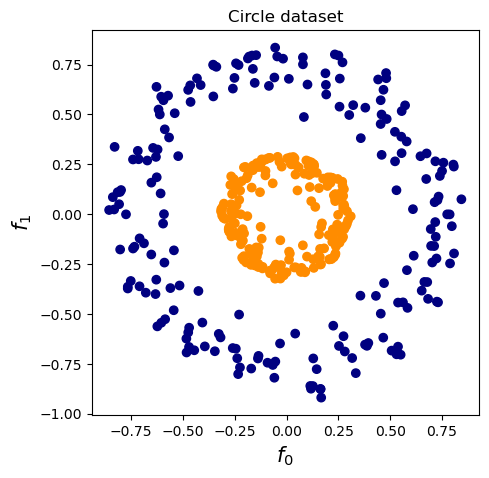

In [40]:
X_reconstructed = kpca.inverse_transform(X_kpca)
colors = ['navy', 'darkorange']
color = [colors[i] for i in y]

plt.figure(figsize=(5,5))
plt.title("Circle dataset")

plt.scatter(X_reconstructed[:, 0], X_reconstructed[:, 1], color=color)

plt.xlabel(r'$f_0$', fontsize=15)
plt.ylabel(r'$f_1$', fontsize=15)
plt.show()

## 4.5. Otras Aplicaciones de PCA:

En el siguiente enlace se presenta un ejemplo de aplicación de PCA para la reducción de características en imágenes de rostros:

https://alceballosa.shinyapps.io/Trabajo3/

#  5. Introducción al Reconocimiento de Patrones

<center><img src = res/patron.png></center>

El Reconocimiento de Patrones es la última etapa dentro de un sistema de visión artificial, en la que a partir de las características encontradas, los posibles objetos se clasifican en dos o más clases.

<center><img src = res/neural.png></center>

Clasificar (o reconocer) significa, en este contexto, asociar a clases (o prototipos) una serie de elementos (u objetos). Esta asociación se realiza en base a las características o propiedades de los objetos.


<center><img src = res/ia.png></center>
<center><img src = res/class.png></center>

Importante: Si los descriptores elegidos son adecuados, objetos similares tendrán patrones próximos en el espacio de características.

- Patrones que describen objetos de una misma clase, presentan características similares.
- Patrones que describen objetos de diferentes clases presentan características diferenciadas.

<center><img src = res/diff.png></center>

#  5.1. Tipos de Clasificadores

Atendiendo a la información que se proporciona en el proceso de construcción del clasificador se puede hablar de dos tipos de clasificadores: supervisados y no supervisados:

- **Clasificadores NO Supervisados**: Sin la necesidad de ningún supervisor externo, el clasificador determina las clases que representan los datos de entrenamiento.

- **Clasificadores Supervisados**: El conjunto de entrenamiento es dividido por el maestro en las diferentes clases ya conocidas en las que se desea clasificar, así el clasificador aprende las características que definen cada clase.

Hoy nos centraremos en los clasificadores supervisados.

# 5.1.1. Modelo General de un Clasificador Supervisado

Aplicar una función de predicción en una representación de las características de la imagen para obtener el resultado deseado

<center><img src = res/supervisado.png></center>

- Entrenamiento: Dado un conjunto de ejemplos {(x1, y1), ..., (xn, yn)}, calcular la predicción de la función f, reduciendo al mínimo el error de predicción en el conjunto de entrenamiento.


<img src = res/train.png>

# 5.1.2. Algunos Clasificadores Supervisados

Los métodos para clasificación supervisada son muy diversos. Entre ellos se encuentran:

- Regresión Logística.
- Clasificadores Bayesianos.
- Máquinas de Soporte Vectorial.
- Redes Neuronales.
- Árboles de Decisión/Bosques Aleatorios.
- K-Vecinos más cercanos.

En el día de hoy nos centraremos en uno de los métodos más básicos: **regresión logística.** Antes, sin embargo, introduciremos algunos conceptos básicos con base en la regresión lineal.

# 5.1.3. Regresión Lineal

La regresión lineal permite estimar una variable de respuesta continua a partir de un conjunto de variables (atributos o características) de entrada $x_i$, unos pesos $W_i$ y un sesgo/intercepto $b$.

Se define de la siguiente manera para el dataset entero:

$$\LARGE a = W^{T}\cdot x + b $$

Lo que equivale a:

$$\LARGE a = \sum_{j=1}^n w_j x_j + b $$


Donde $a$ es el valor predicho, $x$ es el arreglo con las instancias de entrada y $W$ es el arreglo con los pesos asignados. Luego $w_i$ es el peso asignado a la característica $x_i$, con $n$ = número de características.

Una posibilidad para definir la función de perdida es el error cuadrático medio,donde $m$ es el número de muestras con la que se construyó la regresión:

$$\LARGE L = \frac{1}{m} \sum_{i=1}^m (y_i - a_i)^2 $$

### Detalles de Implementación:

* $X$ es una matriz de $n$ filas y $m$ columnas, donde $n$ es el número de atributos y $m$ es el número de instancias en el conjunto de datos.

* $Y$ es un vector fila de 1 fila  y $m$ columnas.

(1, 25)
(1, 25)


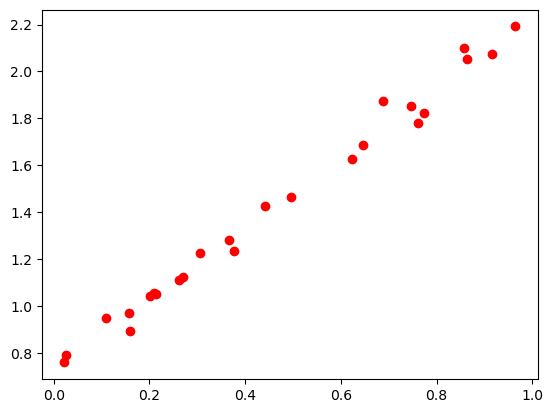

In [41]:
#Generar array X,Y

X = np.array([[0.1087,  0.2698,  0.3765,  0.2146,  0.9155,
     0.0246,  0.0221,  0.8632,  0.6460,  0.2092,
     0.8567,  0.1591,  0.9647,  0.6231,  0.7460,
     0.3654,  0.3065,  0.6886,  0.4966,  0.2008,
     0.2618,  0.7607,  0.1563,  0.4424,  0.7731]])

Y = np.array([[0.9519,  1.1237,  1.2360,  1.0526,  2.0743,
     0.7906,  0.7603,  2.0533,  1.6887,  1.0563,
     2.0991,  0.8953,  2.1917,  1.6266,  1.8508,
     1.2828,  1.2283,  1.8722,  1.4657,  1.0418,
     1.1097,  1.7826,  0.9711,  1.4267,  1.8248]])

#Imprimir el tamaño de X e Y
print(X.shape)
print(Y.shape)

#Plotear con matplotlib X vs Y
plt.scatter(X, Y, color='r');

* W es un vector de pesos con la forma (n, 1), que luego se trabaja transpuesto, que puede ser inicializado en 0 o aleatoriamente. Aquí lo hacemos en 1.

0.9454462316


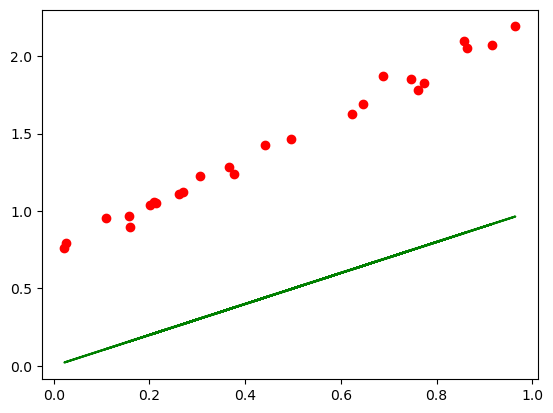

In [42]:
#Vectorizar el problema
n = X.shape[0]
m = X.shape[1]
W = np.ones((n,1))
b = 0

#Probemos a predecir a partir del vector de pesos inicial
A = np.dot(W.T, X) + b
L = np.sum(np.power(Y-A,2))/m
print(L)
plt.scatter(X, Y, color='r')
plt.plot(X[0], A[0], 'g');

## Ajustando los Pesos Mediante Descenso por Gradiente

Para obtener los pesos que minimicen el error aplicaremos la técnica iterativa conocida como descenso por gradiente.

<center><img src = res/height.png></center>


### Regla de Actualización de Pesos:

Actualizaremos los pesos y el intercepto a partir de la siguiente regla:

$$ W_{new} = W - \rho \Delta W $$

$$ b_{new} = b - \rho \Delta b $$

Donde $\rho$ es una tasa de aprendizaje que determina qué tanto modificaremos los pesos según el valor de $\Delta W$.


**Cálculo de $\Delta W$  y $\Delta b$**

El cambio para un peso w está definido como la derivada parcial de la función de perdida $L$ con respecto a ese peso.

$$ \Delta w_j  = \frac{ \partial L }{\partial w_j}  $$

Por regla de la cadena:
$$\frac{ \partial L }{\partial w_j}  = \frac{\partial a}{\partial w_j} \frac{\partial L}{\partial a} $$

$$L = \frac{1}{m}  \sum_{i=1}^m (y_i - a_i)^2 $$
$$\frac{ \partial L }{ \partial a} = - \frac{2}{m} \sum_{i=1}^m (y_i - a_i) $$
$$a = \sum_{j=1}^n w_j x_j + b $$
$$\frac{ \partial a }{ \partial w_j} = x_{i,j} $$

$$\frac{ \partial L }{\partial w_j}  =  - \frac{2}{m} \sum_{i=1}^m (y_i - a_i)  x_{i,j} $$

Lo anterior puede reducirse aplicando algebra matricial a:

$$\frac{ \partial L }{\partial W}  =  - \frac{2}{m}  (Y - A) \cdot X^T $$

Y análogamente:

$$\frac{ \partial L }{\partial b}  =  - \frac{2}{m} \sum_{i=1}^m (y_i - a_i) $$

Nota: En el código denotaremos a cada derivada parcial como $\Delta denominador$

0.002087022798644724


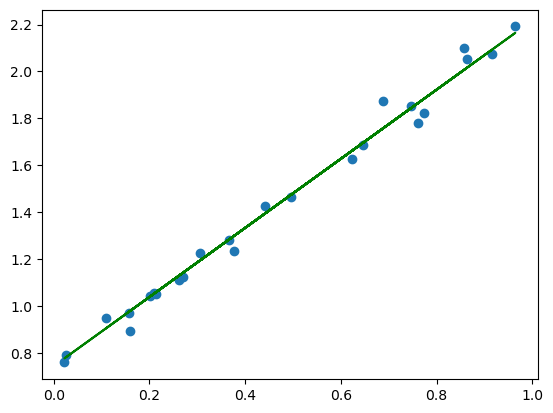

In [43]:
#Realizar un ajuste de pesos sobre la regresión lineal hasta encontrar la línea que mejor se ajuste
n = X.shape[0]
m = X.shape[1]
W = np.ones((n,1))
b = 0

#Learning_rate o alpha debe ser relativamente pequeño para asegurar la convergencia del método del gradiente descendente
learning_rate = 0.001

#Realizar 10000 iteraciones
for i in range(10000):
    A = np.dot(W.T, X) + b


    dW = -(2/m) * (np.dot(Y - A, X.T ))

    db = -(2/m) * np.sum( Y - A )

    W = W - learning_rate*dW
    b = b - learning_rate*db

    A = np.dot(W.T, X) + b
    L = np.sum(np.power(Y-A,2))/m

print(L)
plt.scatter(X, Y)
plt.plot(X[0], A[0], 'g-');

A continuación probemos el código desarrollado en el dataset de diabetes, y comparemos con la función implementada por Scikit-Learn...

In [44]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Load the diabetes dataset
diabetes = datasets.load_diabetes()

X = diabetes.data.T
Y = diabetes.target.reshape(1,len(diabetes.target))
n = X.shape[0]
m = X.shape[1]
W = np.ones((n,1))
b = 0
learning_rate = 0.3

losses = []

# Método del gradiente descendente
for i in range(100000):
    A = np.dot(W.T, X) + b
    dW = -(2/m) * ( np.dot(Y - A, X.T ))
    db = -(2/m) * np.sum( Y - A )

    W = W - learning_rate*dW.T
    b = b - learning_rate*db

    A = np.dot(W.T, X) + b
    L = np.sum(np.power(Y-A,2))/m
    losses.append(L)
print(L)
print(W)

2861.8848914859072
[[  -8.91315231]
 [-238.58518489]
 [ 522.6183413 ]
 [ 323.30152636]
 [-553.58466733]
 [ 287.42038705]
 [  -5.66530379]
 [ 146.61055298]
 [ 662.37304325]
 [  68.50422435]]


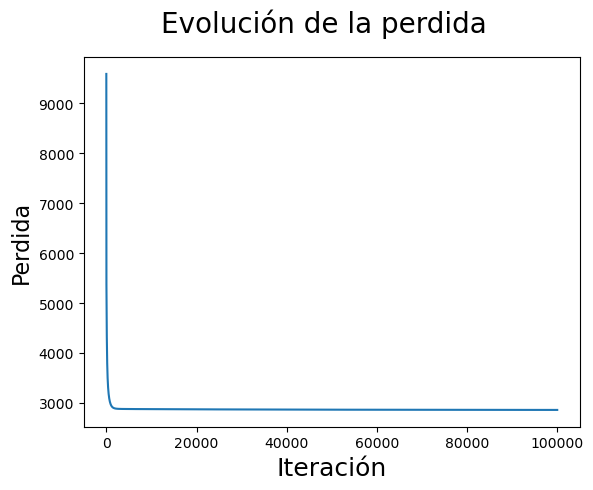

In [45]:
fig = plt.figure()
plt.plot(losses)
fig.suptitle('Evolución de la perdida', fontsize=20)
plt.xlabel('Iteración', fontsize=18)
plt.ylabel('Perdida', fontsize=16);

In [46]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X.T, Y[0])

In [47]:
A = reg.predict(X.T)
L = np.sum(np.power(Y-A,2))/m
print(L)
print(reg.coef_)

2859.6963475867506
[ -10.0098663  -239.81564367  519.84592005  324.3846455  -792.17563855
  476.73902101  101.04326794  177.06323767  751.27369956   67.62669218]


# 5.1.4. Regresión Logística

La regresión logística se puede considerar una modificacón de la regresión lineal (modelo lineal generalizado). En este caso, en vez de predecir una variable de respuesta continua, se predice una variable de respuesta categórica, tal que:

$$\LARGE z =  W^{T}X + b $$
$$\LARGE a = \sigma(z)$$

Donde:

$$\LARGE \sigma(z) = \frac{1}{1 + e^{-z}}$$


<center><img src = "res/logistic.png"  width="75%"></center>

Debido a la forma de la función sigmoidea, los valores resultantes están entre 0 y 1, lo que la hace muy útil para la tarea de clasificación binaria.

Considerando lo anterior se decide usar una función de pérdida de entropía cruzada, definida como sigue para un conjunto de $m$ datos:

$$\LARGE L = \frac{1}{m} \cdot \sum_{i=0}^{m-1} - y \cdot log(a) - (1-y) \cdot log(1- a) $$



In [48]:
df_train = pd.read_csv('data_train.csv')
df_test = pd.read_csv('data_test.csv')
df_test.head()

,Unnamed: 0,hu0,hu1,hu2,hu3,hu4,hu5,hu6,euler_num,orientation,area_to_convex_ratio,compacity,roundness,area_perimeter_ratio,elongation,solidity1,solidity2,class
0,0,-0.804802,-3.138292,-2.844154,-5.174724,9.957690,11.647921,-9.303848,1,-0.093700,0.522523,45.776253,0.274517,1.591875,1.656137,0.522523,1.000000,7
1,1,-0.962441,-3.503293,-4.015799,-6.463361,12.625727,8.251841,11.788889,1,0.340228,0.550000,52.158727,0.240926,1.778601,1.632293,0.550000,1.000000,2
2,2,-0.525733,-1.140627,-5.777995,-6.137164,-12.094743,-6.707824,19.440251,1,-0.292252,0.780488,34.724702,0.361886,1.357597,6.698557,0.780488,1.000000,1
3,3,-1.404304,-5.665310,-7.427943,-10.728971,-20.642337,14.685048,-19.911730,0,-0.181032,0.759843,41.369827,0.303757,2.159916,1.276931,0.759843,0.807531,0
4,4,-0.986712,-7.854811,-4.475459,-7.592898,14.613329,-12.411038,13.701969,1,0.472922,0.504202,55.904383,0.224783,1.465101,1.054301,0.504202,1.000000,4


In [49]:
df_train = df_train.drop(columns=['Unnamed: 0'])
df_test =  df_test.drop(columns=['Unnamed: 0'])
df_test.head()

,hu0,hu1,hu2,hu3,hu4,hu5,hu6,euler_num,orientation,area_to_convex_ratio,compacity,roundness,area_perimeter_ratio,elongation,solidity1,solidity2,class
0,-0.804802,-3.138292,-2.844154,-5.174724,9.957690,11.647921,-9.303848,1,-0.093700,0.522523,45.776253,0.274517,1.591875,1.656137,0.522523,1.000000,7
1,-0.962441,-3.503293,-4.015799,-6.463361,12.625727,8.251841,11.788889,1,0.340228,0.550000,52.158727,0.240926,1.778601,1.632293,0.550000,1.000000,2
2,-0.525733,-1.140627,-5.777995,-6.137164,-12.094743,-6.707824,19.440251,1,-0.292252,0.780488,34.724702,0.361886,1.357597,6.698557,0.780488,1.000000,1
3,-1.404304,-5.665310,-7.427943,-10.728971,-20.642337,14.685048,-19.911730,0,-0.181032,0.759843,41.369827,0.303757,2.159916,1.276931,0.759843,0.807531,0
4,-0.986712,-7.854811,-4.475459,-7.592898,14.613329,-12.411038,13.701969,1,0.472922,0.504202,55.904383,0.224783,1.465101,1.054301,0.504202,1.000000,4


In [50]:
# Filtrar aquellas cuya columna class sea 0 o 1
df_train = df_train.loc[df_train['class'].isin([0.0,1.0])]
df_test = df_test.loc[df_test['class'].isin([0.0,1.0])]
# Eliminar las filas cuyas columnas tienen un elemento NaN por el filtro anterior
df_train = df_train.dropna()
df_test = df_test.dropna()
df_test.head()

,hu0,hu1,hu2,hu3,hu4,hu5,hu6,euler_num,orientation,area_to_convex_ratio,compacity,roundness,area_perimeter_ratio,elongation,solidity1,solidity2,class
2,-0.525733,-1.140627,-5.777995,-6.137164,-12.094743,-6.707824,19.440251,1,-0.292252,0.780488,34.724702,0.361886,1.357597,6.698557,0.780488,1.000000,1
3,-1.404304,-5.665310,-7.427943,-10.728971,-20.642337,14.685048,-19.911730,0,-0.181032,0.759843,41.369827,0.303757,2.159916,1.276931,0.759843,0.807531,0
5,-0.766534,-1.679143,-7.011128,-8.600345,-17.069865,-11.174201,16.560107,1,-0.319257,0.803922,28.549836,0.440156,1.694748,5.234049,0.803922,1.000000,1
10,-0.918804,-4.901181,-7.617227,-9.557995,-18.169413,-12.790344,-19.679770,0,-0.269968,0.561462,67.978460,0.184858,1.576731,1.245595,0.561462,0.582759,0
13,-1.081063,-5.040159,-10.497057,-7.733873,18.068203,-10.300495,-16.895044,0,-0.032234,0.619926,56.499433,0.222416,1.724378,1.273493,0.619926,0.646154,0


In [51]:
# Usamos el método values que comvierte el dataframe en un Numpy Array
# Para los de entrada X al modelo se toman todas las columnas menos la última que es de la clase
X_train = df_train.values[:,:-1]
# Tomamos la última columna que es la clase, con esto podemos luego evaluar la pérdida
Y_train = df_train.values[:,-1]

# Dejamos los datos en las dimensiones adecuadas
X_train = X_train.T
Y_train = Y_train.reshape((1,len(Y_train)))

# Hacemos lo mismo para los datos de prueba
X_test = df_test.values[:,:-1]
Y_test = df_test.values[:,-1]

X_test = X_test.T
Y_test = Y_test.reshape((1,len(Y_test)))

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(16, 12633) (1, 12633) (16, 2109) (1, 2109)


A continuación implementamos la regresión logística. La derivación correspondiente se encuentra en el pdf adjunto "deriv_log.pdf"

In [52]:
n = X_train.shape[0]
m = X_train.shape[1]
W = np.ones((n,1))
b = 0
learning_rate = 0.01
eps = 0.00000001
losses = []

Z = np.dot(W.T, X_train) + b
A = 1/(1+np.exp(-Z))
for i in range(100):

    dW = np.dot(X_train, (A-Y_train).T)
    db = np.sum(A-Y_train)
    W = W - learning_rate*dW
    b = b - learning_rate*db
    Z = np.dot(W.T, X_train) + b
    A = 1/(1+np.exp(-Z))
    L = -np.sum((Y_train*np.log(eps+A)+((1-Y_train)*np.log(eps+1-A))))/m
    losses.append(L)

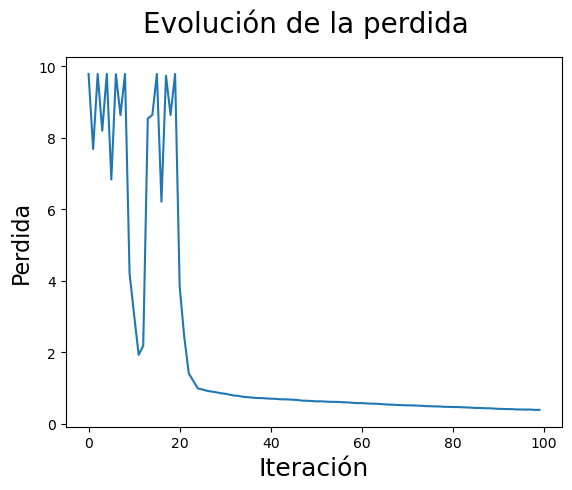

In [53]:
fig = plt.figure()
plt.plot(losses)
fig.suptitle('Evolución de la perdida', fontsize=20)
plt.xlabel('Iteración', fontsize=18)
plt.ylabel('Perdida', fontsize=16);

In [54]:
colnames = df_train.columns.values
weights = W.T[0]
print("Peso relacionado con cada atributo: ")
for i in range(len(colnames)-1):
    print(colnames[i],":\t", weights[i])

print("\n")

# Calculamos ahora con los datos de prueba a ver como lo hace el modelo
Z = np.dot(W.T, X_test) + b
A = 1/(1+np.exp(-Z))

# Binarizamos
A[A>0.5] = 1
A[A<=0.5] = 0

"""La expresión np.sum(np.abs(A-Y_test)) nos da el número de elementos que no coinciden, o sea los errores;
pues si una predicción fue correcta, la suma es cero en dicho elemento, si fue incorrecta, la suma es 1, por 
lo que un error es un 1, y la suma de todos los errores es el número total de errores."""

print("Casos mal clasificados sobre el conjunto de prueba: ", np.sum(np.abs(A-Y_test)), " de ", Y_test.shape[1])
print("Precisión del modelo: ", 1-np.sum(np.abs(A-Y_test))/Y_test.shape[1])

Peso relacionado con cada atributo: 
hu0 :	 65.41929852459367
hu1 :	 1276.956738612808
hu2 :	 -770.7562493227056
hu3 :	 -531.5693462272445
hu4 :	 8.714576489371783
hu5 :	 9.525635531209241
hu6 :	 -10.716033248781441
euler_num :	 939.5952521582459
orientation :	 109.85275075066747
area_to_convex_ratio :	 233.17083395319227
compacity :	 -411.5238945072841
roundness :	 195.99710149315203
area_perimeter_ratio :	 204.7081565743208
elongation :	 3178.834985027722
solidity1 :	 233.17083395319227
solidity2 :	 403.1842799492539


Casos mal clasificados sobre el conjunto de prueba:  33.0  de  2109
Precisión del modelo:  0.984352773826458


## Implementación con Scikit-Learn

In [55]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train.T, Y_train[0])

LogisticRegression()

In [56]:
colnames = df_train.columns.values
weights = model.coef_[0]
print("Peso relacionado con cada atributo: ")
for i in range(len(colnames)-1):
    print(colnames[i],":\t", weights[i])

Peso relacionado con cada atributo: 
hu0 :	 0.3170459704991414
hu1 :	 0.6024798732025612
hu2 :	 0.9585608354817605
hu3 :	 -0.2763799059944724
hu4 :	 0.005341392299211101
hu5 :	 -0.007815459036354454
hu6 :	 -0.010654859272043899
euler_num :	 2.788810999747395
orientation :	 1.3864860417768021
area_to_convex_ratio :	 -1.472546882164434
compacity :	 -0.10839917524807442
roundness :	 0.6232726510216273
area_perimeter_ratio :	 -0.48700521711675077
elongation :	 3.4817233423073333
solidity1 :	 -1.472546882164434
solidity2 :	 3.1391083027876308


In [57]:
A = model.predict(X_test.T)
print("Casos mal clasificados sobre el conjunto de prueba: ", np.sum(np.abs(A-Y_test)), " de ", Y_test.shape[1])

Casos mal clasificados sobre el conjunto de prueba:  4.0  de  2109


In [58]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(A,Y_test[0])
print(conf_matrix)

[[ 979    3]
 [   1 1126]]


# 5.1.5 Otros Algoritmos

In [59]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

#realizar una lectura del dataset de iris
iris = load_iris()

X, y = iris.data, iris.target

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Decision Tree

In [60]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf = clf.fit(x_train, y_train)

In [61]:
y_pred = clf.predict(x_test)

In [62]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred, average='macro'))

Accuracy: 1.0
Precision: 1.0


**OJO: Lo anterior muestra que el Decision Tree es perfecto, pero esto es falso, lo que sucede es que no hay muestras/datos suficientes**

In [63]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a decision tree classifier
clf = DecisionTreeClassifier()

# Train the model on the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

1.0


In [64]:
#Importar datasets preparados para trabajar
from keras.datasets import mnist

#Cargar el dataset, conjuntos de entrenamiento y pruebas
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)
clf = DecisionTreeClassifier()
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

In [65]:
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
precision = metrics.precision_score(y_test, y_pred, average='macro')
print(precision)
recall = metrics.recall_score(y_test, y_pred, average='macro')
print(recall)

0.8791
0.8775906091633068
0.8775268419422251


**Las anteriores son métricas más realistas dado que el dataset empleado de MNIST del Keras, es mucho más amplio y diverso**

## Naive Bayes

In [66]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(x_train, y_train).predict(x_test)

In [67]:
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
precision = metrics.precision_score(y_test, y_pred, average='macro')
print(precision)

0.5558
0.6864966027174797


## SVM

In [68]:
# from sklearn.svm import SVC
# clf = SVC(gamma='auto')
# clf.fit(x_train, y_train)
# y_pred = clf.predict(x_test)

In [69]:
# accuracy = accuracy_score(y_test, y_pred)
# print(accuracy)
# precision = metrics.precision_score(y_test, y_pred, average='macro')
# print(precision)